In [1]:
CONFIG_FILE_DIR = '../experiments/mpii/resnet50/256x256_d256x3_adam_lr1e-3.yaml'
IMAGE_FILE = './pose.jpg'
OUTPUT_IMAGE_SHAPE = (256, 256)

In [2]:
# config
import torch
from models.pose_resnet import get_pose_net
from core.config import config
from core.config import update_config

config.TEST.FLIP_TEST = True
config.TEST.MODEL_FILE = 'pose_resnet_50_256x256.pth.tar'

update_config(CONFIG_FILE_DIR)
model = get_pose_net(config, is_train=False)
model.load_state_dict(torch.load('pose_resnet_50_256x256.pth.tar', map_location=torch.device('cpu')))

import torch
import torchvision.transforms as transforms
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
toTensor = transforms.Compose([transforms.ToTensor(), 
                               transforms.Normalize(mean, std)])


In [3]:
# utils
def getpoint(mat):
    height, width = mat.shape
    mat = mat.reshape(-1)
    idx = np.argmax(mat)
    return idx % width, idx // width

In [4]:
# load image and predict
import cv2
import numpy as np
img = cv2.imread(IMAGE_FILE, cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
img = cv2.resize(img, (256, 256))
x = toTensor(img).unsqueeze(0)
with torch.no_grad():
    res = model.forward(x)
res = np.array(res.detach().squeeze())

print(res.shape[1], res.shape[2])

64 64


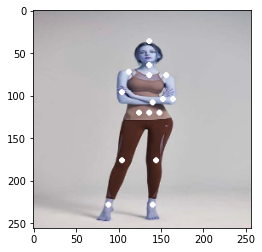

In [5]:
import matplotlib.pyplot as plt
from PIL import Image

def draw_points_on_image(img):
    points_list = []
    image = cv2.resize(img, OUTPUT_IMAGE_SHAPE)
    w, h = OUTPUT_IMAGE_SHAPE
    # print(image.shape)
    r_w, r_h = res.shape[1:]
    for mat in res:
        x, y = getpoint(mat)
        # print(x, y)
        t_x = w/r_w*x
        t_y = h/r_h*y
        t_x, t_y = int(t_x), int(t_y)
        points_list.append((t_x, t_y))
        # print("Transformed : [{} {}]".format(t_x, t_y))
        cv2.circle(image, (t_x, t_y), 2, (255, 255, 255), 2)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image
    
    
#image, points_list = 
image = draw_points_on_image(img)
plt.imshow(image)

In [6]:
import re

JOINTS = ['0 - r ankle', '1 - r knee', '2 - r hip', '3 - l hip', '4 - l knee', '5 - l ankle', '6 - pelvis', '7 - thorax', '8 - upper neck', '9 - head top', '10 - r wrist', '11 - r elbow', '12 - r shoulder', '13 - l shoulder', '14 - l elbow', '15 - l wrist']
JOINTS = [re.sub(r'[0-9]+|-', '', joint).strip().replace(' ', '-') for joint in JOINTS]

In [7]:
POSE_PAIRS = [
# UPPER BODY
              [9, 8],
              [8, 7],
              [7, 6],

# LOWER BODY
              [6, 2],
              [2, 1],
              [1, 0],

              [6, 3],
              [3, 4],
              [4, 5],

# ARMS
              [7, 12],
              [12, 11],
              [11, 10],

              [7, 13],
              [13, 14],
              [14, 15]
]

In [8]:
# Utils
from operator import itemgetter
get_keypoints = lambda pose_layers: map(itemgetter(1, 3), [cv2.minMaxLoc(pose_layer) for pose_layer in pose_layers])

In [9]:
THRESHOLD = 0.6
OUT_HEIGHT, OUT_WIDTH = res.shape[1], res.shape[2]
OUT_SHAPE = (OUT_HEIGHT, OUT_WIDTH)

def get_image_with_points_connected_lines():
    image_p = cv2.imread(IMAGE_FILE)
    pose_layers = res
    key_points = list(get_keypoints(pose_layers=pose_layers))
    is_joint_plotted = [False for i in range(len(JOINTS))]
    for pose_pair in POSE_PAIRS:
        from_j, to_j = pose_pair

        from_thr, (from_x_j, from_y_j) = key_points[from_j]
        to_thr, (to_x_j, to_y_j) = key_points[to_j]

        IMG_HEIGHT, IMG_WIDTH, _ = image_p.shape

        from_x_j, to_x_j = from_x_j * IMG_WIDTH / OUT_SHAPE[0], to_x_j * IMG_WIDTH / OUT_SHAPE[0]
        from_y_j, to_y_j = from_y_j * IMG_HEIGHT / OUT_SHAPE[1], to_y_j * IMG_HEIGHT / OUT_SHAPE[1]

        from_x_j, to_x_j = int(from_x_j), int(to_x_j)
        from_y_j, to_y_j = int(from_y_j), int(to_y_j)

        if from_thr > THRESHOLD and not is_joint_plotted[from_j]:
            # this is a joint
            cv2.ellipse(image_p, (from_x_j, from_y_j), (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
            is_joint_plotted[from_j] = True

        if to_thr > THRESHOLD and not is_joint_plotted[to_j]:
            # this is a joint
            cv2.ellipse(image_p, (to_x_j, to_y_j), (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
            is_joint_plotted[to_j] = True

        if from_thr > THRESHOLD and to_thr > THRESHOLD:
            # this is a joint connection, plot a line
            cv2.line(image_p, (from_x_j, from_y_j), (to_x_j, to_y_j), (255, 74, 0), 2)
    return image_p



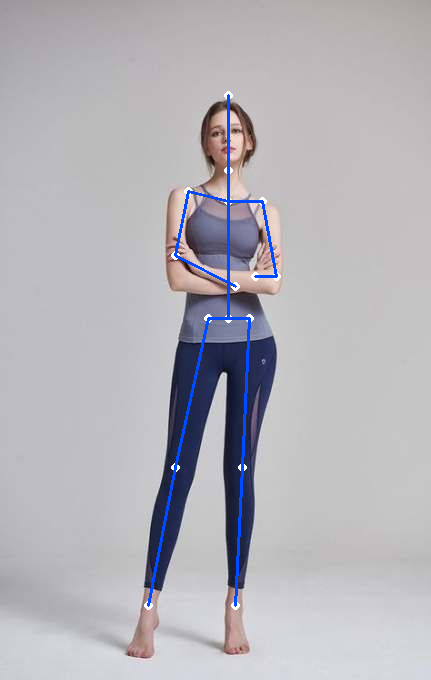

In [10]:
image_p = get_image_with_points_connected_lines()
Image.fromarray(cv2.cvtColor(image_p, cv2.COLOR_RGB2BGR))

In [11]:
import io
import numpy as np
import torch.onnx

# Input to the model
torch_model = model
batch_size = 1
x = torch.randn(batch_size, 3, 256, 256, requires_grad=True)
torch_out = torch_model(x)

# Export the model
torch.onnx.export(torch_model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "simple_pose_estimation_1.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                    )

In [ ]:
import onnx

# Load the onnx model     
model_onnx = onnx.load('./simple_pose_estimation_1.onnx')
onnx.checker.check_model(model_onnx)


In [ ]:
from onnxruntime.quantization import quantize
from onnxruntime.quantization import QuantizationMode

# Quantize
quantized_model = quantize(model_onnx, quantization_mode=QuantizationMode.IntegerOps)
 
# Save the quantized model
onnx.save(quantized_model, 'quantized_model_1.onnx')